In [4]:
from IPython import display

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar

In [33]:
schedule_names = ['fcfs']

In [34]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/fcfs/base_fcfs_schedule.csv']
['../output/fcfs/base_fcfs_jobs.csv']


In [37]:
metrics = pd.DataFrame()
for file in schedule_files:
    _, schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print("reading", file)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

reading ../output/fcfs/base_fcfs_schedule.csv


In [38]:
jobsets = {}
for file in jobs_files:
    _, schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print("reading", file)
        jobsets[schedule_name] = JobSet.from_csv(file)

reading ../output/fcfs/base_fcfs_jobs.csv


In [39]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [84]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [85]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [86]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [87]:
metrics.T

,fcfs
batsim_version,4.0.0
consumed_joules,0
makespan,280.931
max_slowdown,44.8673
max_turnaround_time,55.0139
max_waiting_time,40.922
mean_slowdown,4.1995
mean_turnaround_time,20.2233
mean_waiting_time,12.4819
nb_computing_machines,4


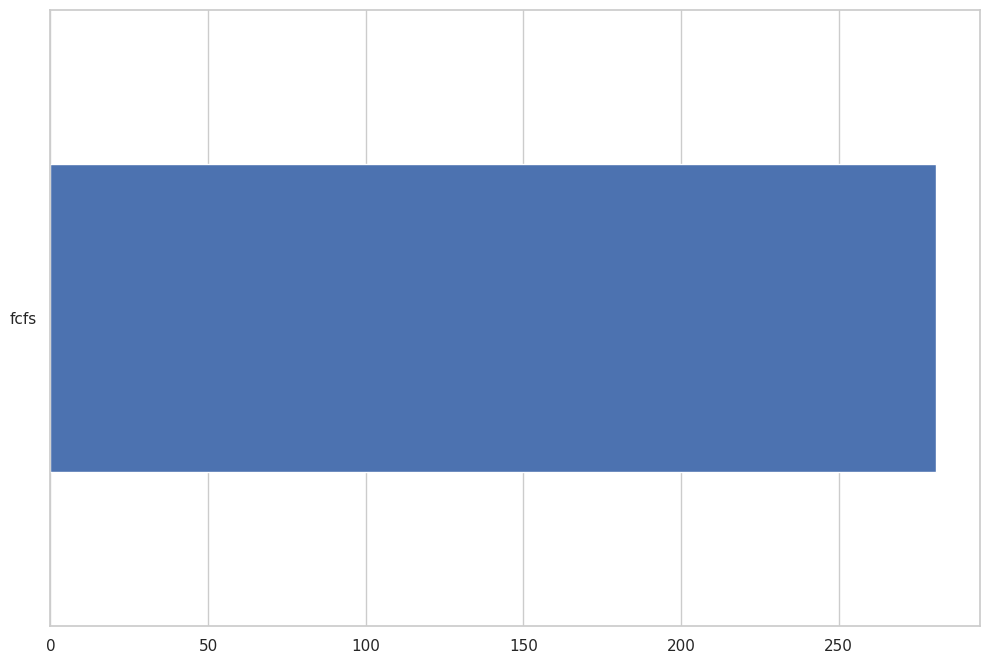

In [88]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

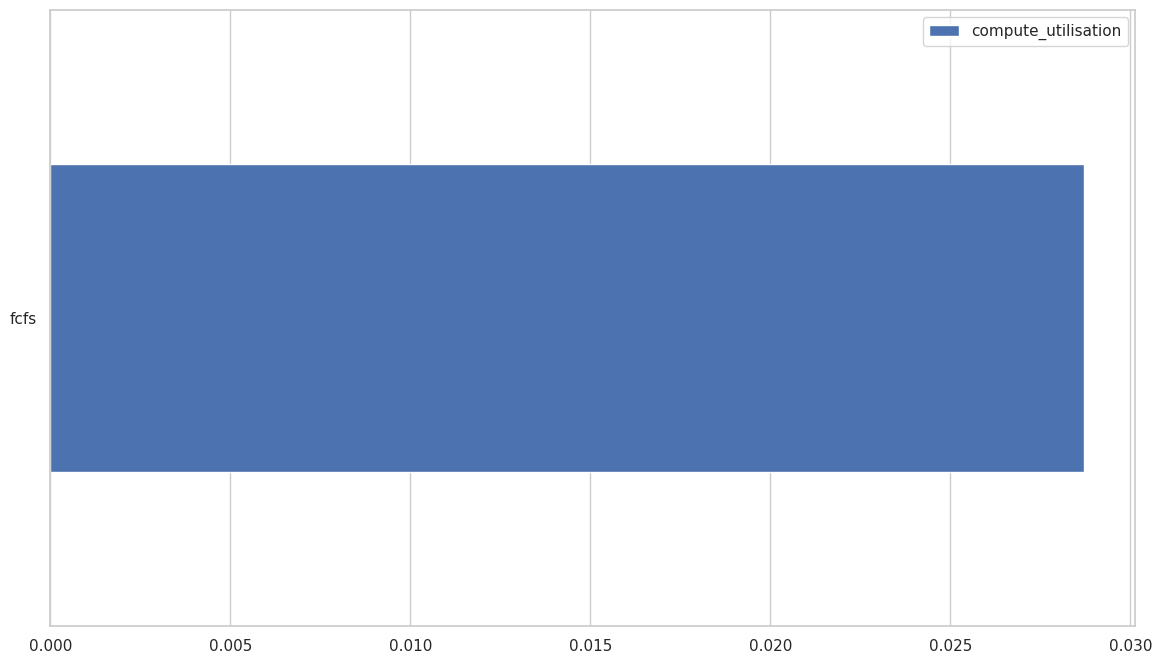

In [89]:
ax = metrics[['compute_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [90]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.500030,8.110253,1.065705
1,fcfs,0.500045,7.853963,1.067997
2,fcfs,8.612239,12.841135,3.036522
3,fcfs,8.612224,14.331186,2.505907
4,fcfs,0.500045,3.187835,1.186043
...,...,...,...,...
95,fcfs,0.500045,5.336929,1.103382
96,fcfs,0.500045,3.921081,1.146168
97,fcfs,1.341909,16.178566,1.090446
98,fcfs,0.500045,2.674378,1.229976


In [49]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs
count,100.000000
mean,12.481948
std,11.688733
min,0.500030
25%,0.500045
50%,11.038095
75%,21.123840
max,40.921953


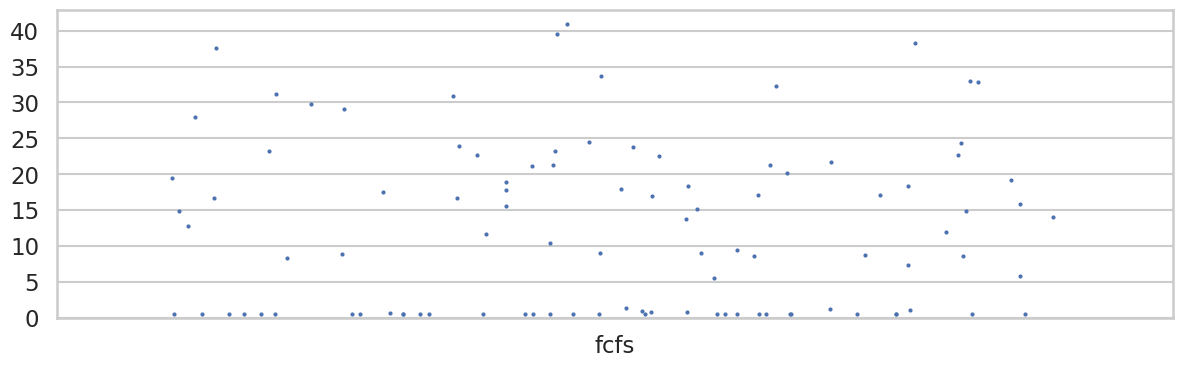

In [54]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

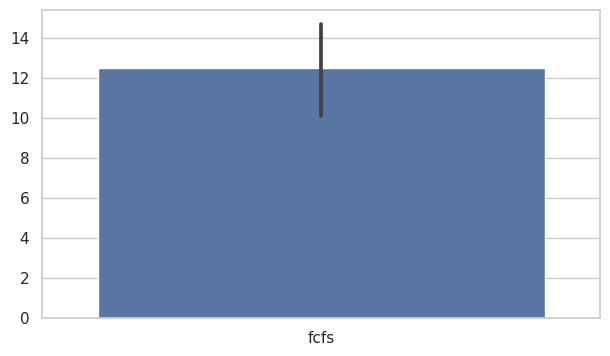

In [57]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

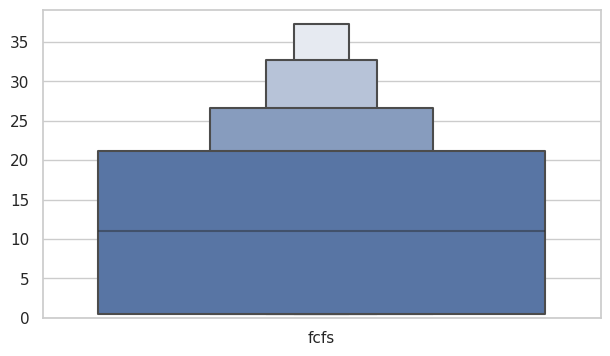

In [58]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

In [59]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs
count,100.000000
mean,20.223265
std,13.040180
min,1.237354
25%,8.371938
50%,19.111500
75%,29.514342
max,55.013868


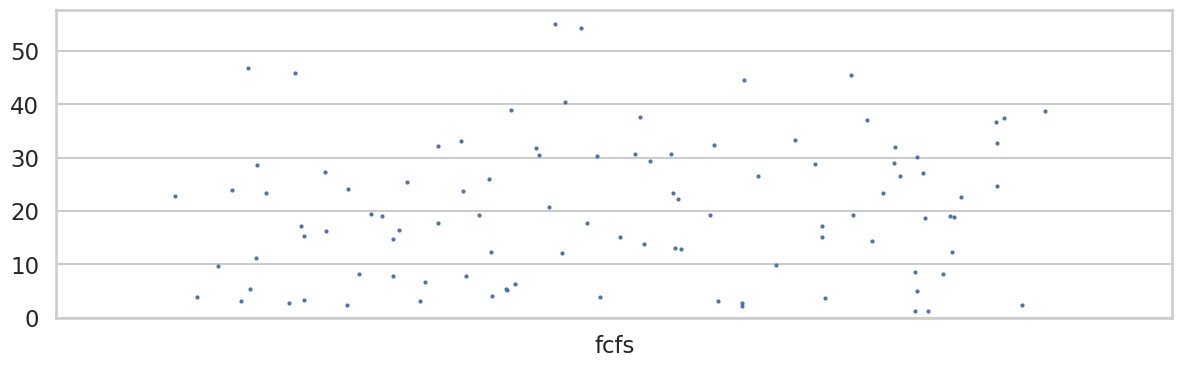

In [60]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

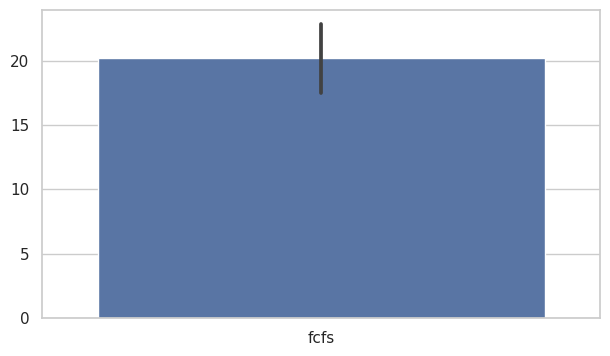

In [61]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

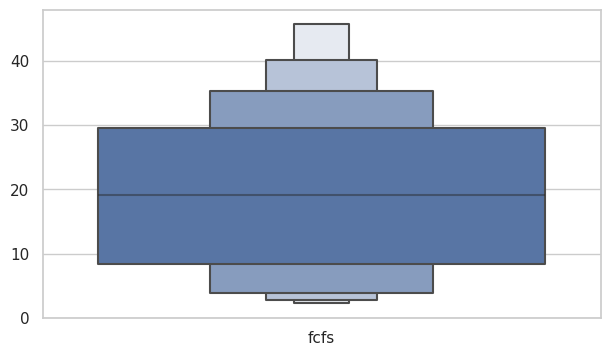

In [62]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

In [63]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs
count,100.000000
mean,4.199502
std,6.633093
min,1.026916
25%,1.166315
50%,2.472715
75%,3.748730
max,44.867339


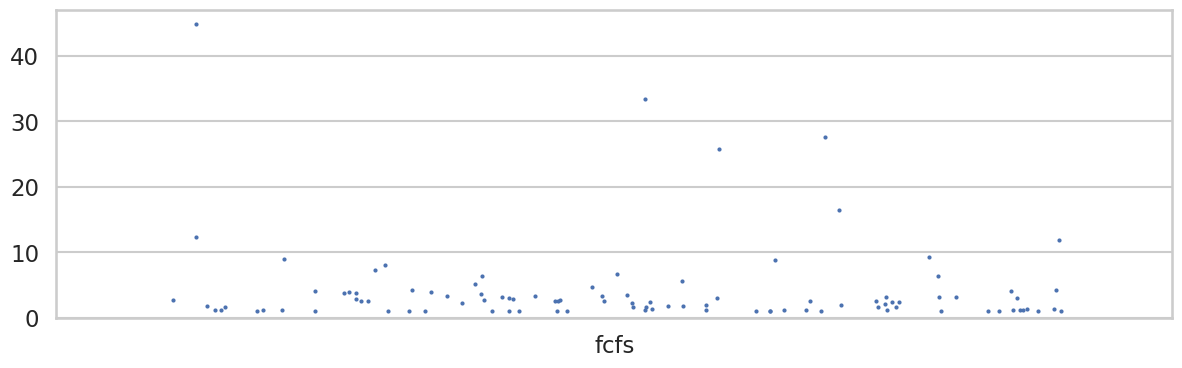

In [65]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

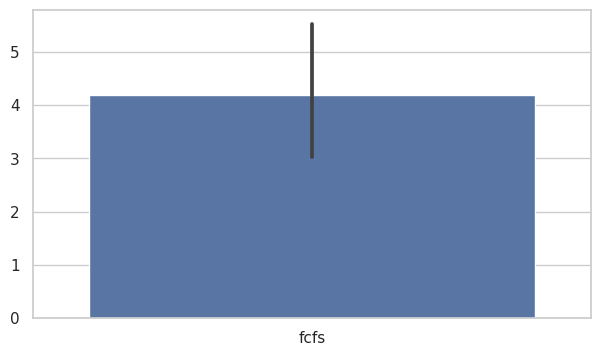

In [66]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

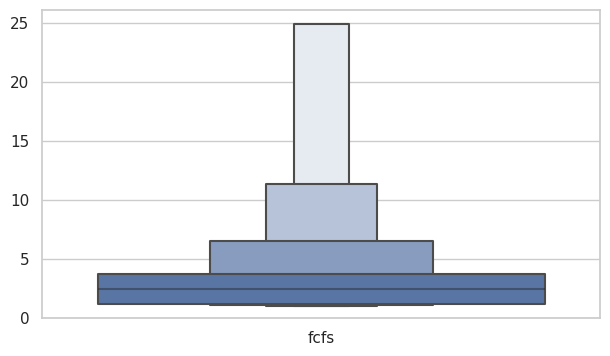

In [67]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

In [76]:
# FCFS

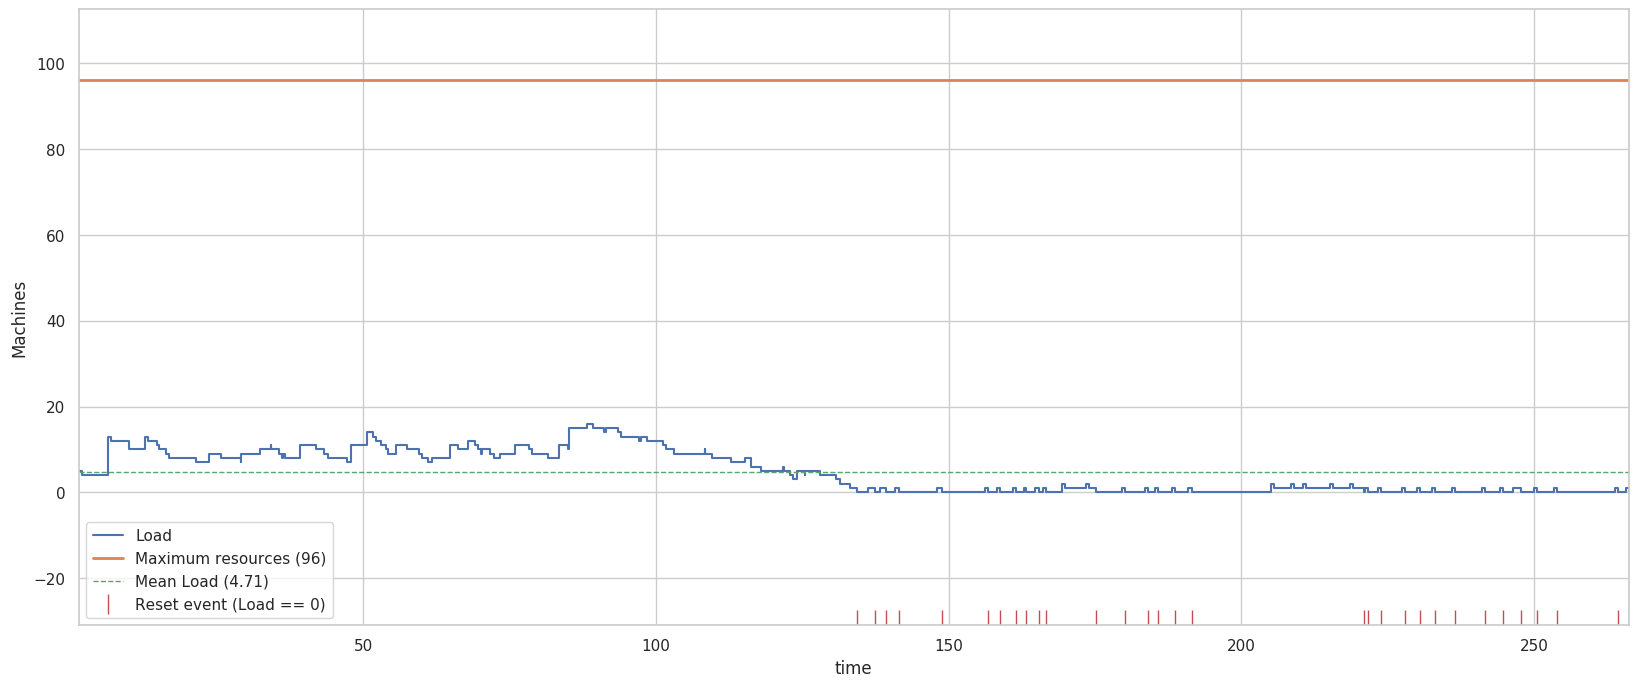

In [77]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

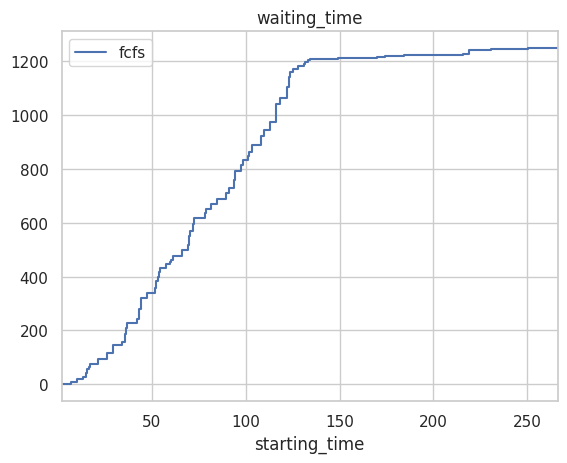

In [78]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)